## Testing CODE

In [12]:
import pandas as pd

# Load the CSV file
file_path = 'China_edited_data.csv'  # Adjust with your actual file path
real_data = pd.read_csv(file_path)
real_data['Observation Date'] = pd.to_datetime(real_data['Observation Date'], format='%d-%m-%Y')

# Aggregate data for the entire country by summing confirmed, deaths, and recovered cases
real_data = real_data.groupby('Observation Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
# Display the first few rows to inspect the structure

In [13]:
# Extract the relevant columns (adjust column names based on the dataset)
infected_data = real_data['Confirmed'] - real_data['Recovered'] - real_data['Deaths']   # Replace with the actual column name for confirmed cases
recovered_data = real_data['Recovered']  # Replace with the actual column name for recovered cases
deaths_data = real_data['Deaths']  # Replace with the actual column name for deaths

# Display the extracted data to confirm


In [14]:
# Assuming a total population N
N = 200000  # Adjust according to your dataset

# Estimate Susceptible (S) compartment
susceptible_data = N - real_data['Confirmed'] - recovered_data - deaths_data

# Assuming a percentage of asymptomatic cases (you can modify this assumption)
percentage_asymptomatic = 0.3  # Assuming 10% of confirmed cases are asymptomatic
asymptomatic_data = percentage_asymptomatic * infected_data

# Display the estimated Susceptible (S) and Asymptomatic (A) data



C:\Users\benou\AppData\Local\Temp\ipykernel_13584\1759134862.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  susceptible_data = torch.tensor(susceptible_data, dtype=torch.float32).reshape(-1, 1)
C:\Users\benou\AppData\Local\Temp\ipykernel_13584\1759134862.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  asymptomatic_data = torch.tensor(asymptomatic_data, dtype=torch.float32).reshape(-1, 1)
C:\Users\benou\AppData\Local\Temp\ipykernel_13584\1759134862.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recovered_data = torch.tenso

Epoch 0, Loss: 18891845632.0, Alpha: 0.09900003671646118, Beta: 0.169000044465065, Gamma: 0.061500001698732376, Delta: 3.958120942115784e-09
Epoch 500, Loss: 18880202752.0, Alpha: 0.00639901589602232, Beta: 0.2287788987159729, Gamma: 0.00034384356695227325, Delta: 0.00033731525763869286


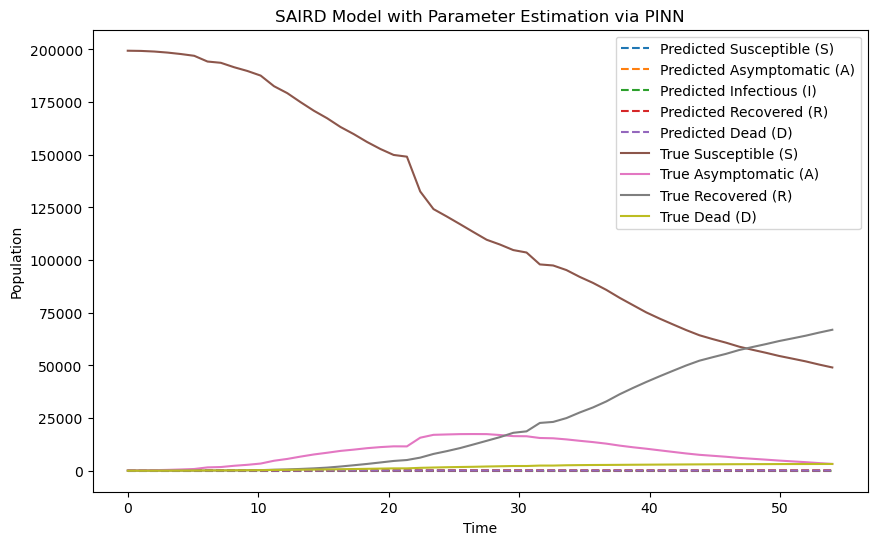

In [15]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Extract the relevant columns for Susceptible (S), Asymptomatic (A), Recovered (R), and Deaths (D)
# susceptible_data = real_data['Susceptible'].values  # Replace with actual column name
# asymptomatic_data = real_data['Asymptomatic'].values  # Replace with actual column name
# recovered_data = real_data['Recovered'].values
# deaths_data = real_data['Deaths'].values

# Total population (adjust as needed)
N = 200000  # Or use the actual total population value if known

# Create time points
t_train = torch.linspace(0, len(susceptible_data), len(susceptible_data)).reshape(-1, 1)
t_train.requires_grad = True

# Convert data to tensors
susceptible_data = torch.tensor(susceptible_data, dtype=torch.float32).reshape(-1, 1)
asymptomatic_data = torch.tensor(asymptomatic_data, dtype=torch.float32).reshape(-1, 1)
recovered_data = torch.tensor(recovered_data, dtype=torch.float32).reshape(-1, 1)
deaths_data = torch.tensor(deaths_data, dtype=torch.float32).reshape(-1, 1)

# Neural network model for estimating SAIRD compartments and parameters
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 5)
        self.activation = torch.tanh

        # Initialize the parameters to be learned
        self.alpha = torch.nn.Parameter(torch.tensor(0.1))
        self.beta = torch.nn.Parameter(torch.tensor(0.17))
        self.gamma = torch.nn.Parameter(torch.tensor(1/16))
        self.delta = torch.nn.Parameter(torch.tensor(0.001))
        self.rho_1 = torch.nn.Parameter(torch.tensor(0.80))
        self.rho_2 = torch.nn.Parameter(torch.tensor(0.29))

    def forward(self, t):
        x = self.activation(self.fc1(t))
        x = self.activation(self.fc2(x))
        output = self.fc3(x)
        return output

# SAIRD model residuals based on the learned parameters
def saird_residuals(model, t):
    SIRD = model(t)
    S, A, I, R, D = SIRD[:, 0], SIRD[:, 1], SIRD[:, 2], SIRD[:, 3], SIRD[:, 4]

    # Derivatives using autograd
    S_t = autograd.grad(S.sum(), t, create_graph=True)[0]
    A_t = autograd.grad(A.sum(), t, create_graph=True)[0]
    I_t = autograd.grad(I.sum(), t, create_graph=True)[0]
    R_t = autograd.grad(R.sum(), t, create_graph=True)[0]
    D_t = autograd.grad(D.sum(), t, create_graph=True)[0]

    # SAIRD equations
    f1 = S_t + model.alpha * A * S + model.beta * I * S 
    f2 = A_t - (1 - model.rho_1) * model.alpha * A * S - model.rho_2 * model.beta * I * S  + model.gamma * A + model.delta * A
    f3 = I_t - (1 - model.rho_2) * model.beta * I * S  - model.rho_1 * model.alpha * A * S  + model.gamma * I + model.delta * I
    f4 = R_t - model.gamma * A - model.gamma * I
    f5 = D_t - model.delta * A - model.delta * I

    return f1, f2, f3, f4, f5

# Loss function combining both data loss and residual loss
def loss_function(model, t, susceptible, asymptomatic, recovered, deaths):
    # Predict Susceptible (S), Asymptomatic (A), Infectious (I), Recovered (R), Dead (D)
    S_pred, A_pred, I_pred, R_pred, D_pred = model(t).T

    # Data loss (mean squared error)
    data_loss = torch.mean((S_pred - susceptible) ** 2) + torch.mean((A_pred - asymptomatic) ** 2) + \
                torch.mean((R_pred - recovered) ** 2) + torch.mean((D_pred - deaths) ** 2)

    # Residual loss from SAIRD ODEs
    f1, f2, f3, f4, f5 = saird_residuals(model, t)
    residual_loss = torch.mean(f1**2) + torch.mean(f2**2) + torch.mean(f3**2) + torch.mean(f4**2) + torch.mean(f5**2)

    return data_loss + residual_loss

# Training the PINN
def train_pinn(model, optimizer, t_train, susceptible, asymptomatic, recovered, deaths, num_epochs=5000):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_function(model, t_train, susceptible, asymptomatic, recovered, deaths)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Alpha: {model.alpha.item()}, Beta: {model.beta.item()}, Gamma: {model.gamma.item()}, Delta: {model.delta.item()}")

# Initialize the model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_pinn(model, optimizer, t_train, susceptible_data, asymptomatic_data, recovered_data, deaths_data, num_epochs=1000)

# Plot the results
with torch.no_grad():
    predictions = model(t_train)

plt.figure(figsize=(10, 6))
plt.plot(t_train.detach().numpy(), predictions[:, 0].detach().numpy(), label='Predicted Susceptible (S)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 1].detach().numpy(), label='Predicted Asymptomatic (A)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 2].detach().numpy(), label='Predicted Infectious (I)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 3].detach().numpy(), label='Predicted Recovered (R)', linestyle='--')
plt.plot(t_train.detach().numpy(), predictions[:, 4].detach().numpy(), label='Predicted Dead (D)', linestyle='--')

plt.plot(t_train.detach().numpy(), susceptible_data.detach().numpy(), label='True Susceptible (S)')
plt.plot(t_train.detach().numpy(), asymptomatic_data.detach().numpy(), label='True Asymptomatic (A)')
plt.plot(t_train.detach().numpy(), recovered_data.detach().numpy(), label='True Recovered (R)')
plt.plot(t_train.detach().numpy(), deaths_data.detach().numpy(), label='True Dead (D)')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SAIRD Model with Parameter Estimation via PINN')
plt.legend()
plt.show()


Epoch 0, Loss: 852972.625
Epoch 100, Loss: 832372.6875
Epoch 200, Loss: 819642.3125
Epoch 300, Loss: 807526.6875
Epoch 400, Loss: 795716.5
Epoch 500, Loss: 784116.8125
Epoch 600, Loss: 772687.875
Epoch 700, Loss: 761409.375
Epoch 800, Loss: 750269.3125
Epoch 900, Loss: 739259.5
Epoch 1000, Loss: 728373.9375
Epoch 1100, Loss: 717608.0
Epoch 1200, Loss: 706957.875
Epoch 1300, Loss: 696420.25
Epoch 1400, Loss: 685992.5625
Epoch 1500, Loss: 675672.1875
Epoch 1600, Loss: 665457.0625
Epoch 1700, Loss: 655345.0625
Epoch 1800, Loss: 645334.5
Epoch 1900, Loss: 635423.75
Epoch 2000, Loss: 625611.1875
Epoch 2100, Loss: 615895.625
Epoch 2200, Loss: 606275.5
Epoch 2300, Loss: 596749.625
Epoch 2400, Loss: 587316.9375
Epoch 2500, Loss: 577976.25
Epoch 2600, Loss: 568726.625
Epoch 2700, Loss: 559566.875
Epoch 2800, Loss: 550496.4375
Epoch 2900, Loss: 541514.3125
Epoch 3000, Loss: 532619.6875
Epoch 3100, Loss: 523811.90625
Epoch 3200, Loss: 515090.03125
Epoch 3300, Loss: 506453.5
Epoch 3400, Loss: 4979

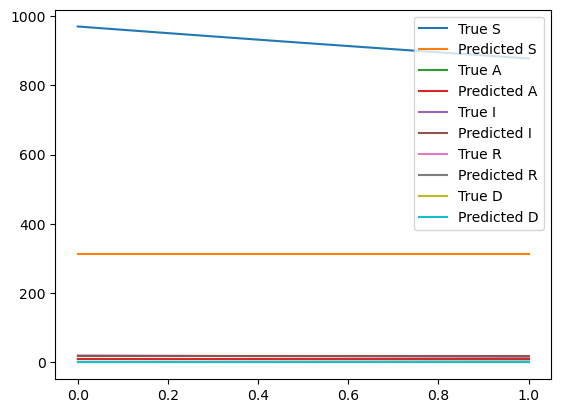

In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Define the SAIRD model parameters
class SAIRD_PINN(nn.Module):
    def __init__(self):
        super(SAIRD_PINN, self).__init__()
        # Neural network with 4 hidden layers, 64 neurons each
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5)  # Output: S, A, I, R, D
        )
        # Initial guess for the model parameters (learned during training)
        self.beta1 = torch.tensor(0.25, requires_grad=True)
        self.beta2 = torch.tensor(0.15, requires_grad=True)
        self.gamma1 = torch.tensor(0.05, requires_grad=True)
        self.gamma2 = torch.tensor(0.03, requires_grad=True)
        self.gamma3 = torch.tensor(0.01, requires_grad=True)
        self.kappa1 = torch.tensor(0.01, requires_grad=True)
        self.kappa2 = torch.tensor(0.01, requires_grad=True)
        self.mu = torch.tensor(0.0001, requires_grad=True)
        self.Lambda = torch.tensor(0.0001, requires_grad=True)

    def forward(self, t):
        # Forward pass to get the predicted values
        S, A, I, R, D = torch.split(self.network(t), 1, dim=1)
        return S, A, I, R, D

# Derivatives for the loss function
def derivatives(y, t):
    return grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]

# Loss function combining data and residual loss
def loss_fn(model, t, data, N):
    S, A, I, R, D = model(t)
    
    # ODE residuals
    dS_dt = derivatives(S, t)
    dA_dt = derivatives(A, t)
    dI_dt = derivatives(I, t)
    dR_dt = derivatives(R, t)
    dD_dt = derivatives(D, t)

    # Loss terms from SAIRD ODEs
    residual_loss = (
        dS_dt - model.Lambda + model.beta1 * S * A + model.beta2 * S * I + model.mu * S
        + dA_dt - model.beta1 * S * A + (model.gamma1 + model.gamma2 + model.gamma3) * A + model.mu * A
        + dI_dt - model.beta2 * S * I - model.gamma1 * A + (model.kappa1 + model.kappa2) * I + model.mu * I
        + dR_dt - model.gamma2 * A - model.kappa1 * I + model.mu * R
        + dD_dt - model.gamma3 * A - model.kappa2 * I
    )
    
    # Data loss
    data_loss = torch.mean((S - data[:, 0]) ** 2 + (A - data[:, 1]) ** 2 + (I - data[:, 2]) ** 2 +
                           (R - data[:, 3]) ** 2 + (D - data[:, 4]) ** 2)

    # Total loss
    return data_loss + torch.mean(residual_loss ** 2)

# Training loop
def train(model, t, data, epochs, N, optimizer):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t, data, N)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Generating synthetic data (for validation) or loading real data
def generate_synthetic_data():
    t = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1, 1)  # Time points
    S = 970 * torch.exp(-0.1 * t)
    A = 10 * torch.exp(-0.1 * t)
    I = 20 * torch.exp(-0.2 * t)
    R = 0 * torch.exp(0.05 * t)
    D = 0 * torch.exp(0.01 * t)
    data = torch.cat([S, A, I, R, D], dim=1)
    return t, data

# Main execution
if __name__ == "__main__":
    # Generate synthetic data (or replace with actual COVID data for China)
    t, data = generate_synthetic_data()
    
    # Initialize the model and optimizer
    model = SAIRD_PINN()
    optimizer = torch.optim.Adam([
        {'params': model.network.parameters()},
        {'params': [model.beta1, model.beta2, model.gamma1, model.gamma2, model.gamma3, model.kappa1, model.kappa2, model.mu, model.Lambda]}
    ], lr=1e-3)
    
    # Train the model
    N = 1000  # Total population
    train(model, t, data, epochs=5000, N=N, optimizer=optimizer)
    
    # Plot results (predicted vs. true)
    with torch.no_grad():
        S_pred, A_pred, I_pred, R_pred, D_pred = model(t)
        
        plt.plot(t, data[:, 0], label="True S")
        plt.plot(t, S_pred, label="Predicted S")
        
        plt.plot(t, data[:, 1], label="True A")
        plt.plot(t, A_pred, label="Predicted A")
        
        plt.plot(t, data[:, 2], label="True I")
        plt.plot(t, I_pred, label="Predicted I")
        
        plt.plot(t, data[:, 3], label="True R")
        plt.plot(t, R_pred, label="Predicted R")
        
        plt.plot(t, data[:, 4], label="True D")
        plt.plot(t, D_pred, label="Predicted D")
        
        plt.legend()
        plt.show()


Epoch 0, Loss: 20069249024.0
Epoch 100, Loss: 20065798144.0
Epoch 200, Loss: 20063221760.0
Epoch 300, Loss: 20060729344.0
Epoch 400, Loss: 20058275840.0
Epoch 500, Loss: 20055834624.0
Epoch 600, Loss: 20053409792.0
Epoch 700, Loss: 20050989056.0
Epoch 800, Loss: 20048572416.0
Epoch 900, Loss: 20046163968.0
Epoch 1000, Loss: 20043755520.0
Epoch 1100, Loss: 20041353216.0
Epoch 1200, Loss: 20038950912.0
Epoch 1300, Loss: 20036552704.0
Epoch 1400, Loss: 20034154496.0
Epoch 1500, Loss: 20031758336.0
Epoch 1600, Loss: 20029364224.0
Epoch 1700, Loss: 20026972160.0
Epoch 1800, Loss: 20024578048.0
Epoch 1900, Loss: 20022190080.0
Epoch 2000, Loss: 20019800064.0
Epoch 2100, Loss: 20017412096.0
Epoch 2200, Loss: 20015024128.0
Epoch 2300, Loss: 20012636160.0
Epoch 2400, Loss: 20010250240.0
Epoch 2500, Loss: 20007864320.0
Epoch 2600, Loss: 20005484544.0
Epoch 2700, Loss: 20003096576.0
Epoch 2800, Loss: 20000712704.0
Epoch 2900, Loss: 19998330880.0
Epoch 3000, Loss: 19995951104.0
Epoch 3100, Loss: 19

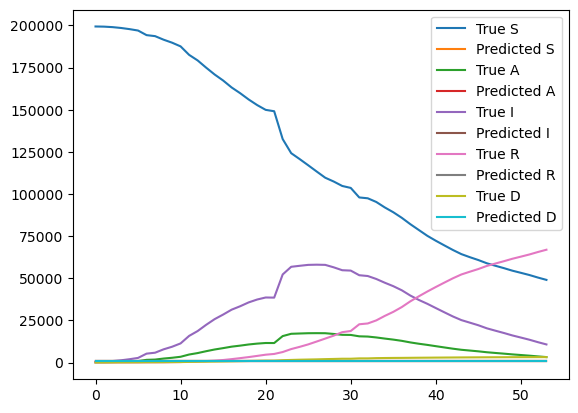

In [16]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Load real data from CSV
def load_real_data(file_path):
    # data = pd.read_csv(file_path)
    # Ensure columns match ['Date', 'Susceptible', 'Asymptomatic', 'Infected', 'Recovered', 'Dead']
    # You can adjust the column names depending on your dataset.
    t = torch.tensor(infected_data.index.values, dtype=torch.float32, requires_grad=True).reshape(-1, 1)  # Time (in days)
    
    # Normalize data based on population size (replace 1000 with actual population size)
    N = 200000  # Replace with actual population size
    # S = torch.tensor(data['Susceptible'].values, dtype=torch.float32).reshape(-1, 1) / N
    # A = torch.tensor(data['Asymptomatic'].values, dtype=torch.float32).reshape(-1, 1) / N
    # I = torch.tensor(data['Infected'].values, dtype=torch.float32).reshape(-1, 1) / N
    # R = torch.tensor(data['Recovered'].values, dtype=torch.float32).reshape(-1, 1) / N
    # D = torch.tensor(data['Dead'].values, dtype=torch.float32).reshape(-1, 1) / N

    S = torch.tensor(susceptible_data.values, dtype=torch.float32).reshape(-1, 1)
    A = torch.tensor(asymptomatic_data.values, dtype=torch.float32).reshape(-1, 1)
    I = torch.tensor(infected_data.values, dtype=torch.float32).reshape(-1, 1)
    R = torch.tensor(recovered_data.values, dtype=torch.float32).reshape(-1, 1)
    D = torch.tensor(deaths_data.values, dtype=torch.float32).reshape(-1, 1)
    
    # Combine data into one tensor
    real_data = torch.cat([S, A, I, R, D], dim=1)
    
    return t, real_data, N

# Main execution for real data
if __name__ == "__main__":
    # Replace 'china_covid_data.csv' with the actual path to your dataset
    file_path = 'china_covid_data.csv'
    t, data, N = load_real_data(file_path)
    
    # Initialize the model and optimizer
    model = SAIRD_PINN()
    optimizer = torch.optim.Adam([
        {'params': model.network.parameters()},
        {'params': [model.beta1, model.beta2, model.gamma1, model.gamma2, model.gamma3, model.kappa1, model.kappa2, model.mu, model.Lambda]}
    ], lr=1e-3)
    
    # Train the model on real data
    train(model, t, data, epochs=10000, N=N, optimizer=optimizer)
    
    # Plot results (predicted vs. true)
    with torch.no_grad():
        S_pred, A_pred, I_pred, R_pred, D_pred = model(t)
        
        plt.plot(t, data[:, 0], label="True S")
        plt.plot(t, S_pred, label="Predicted S")
        
        plt.plot(t, data[:, 1], label="True A")
        plt.plot(t, A_pred, label="Predicted A")
        
        plt.plot(t, data[:, 2], label="True I")
        plt.plot(t, I_pred, label="Predicted I")
        
        plt.plot(t, data[:, 3], label="True R")
        plt.plot(t, R_pred, label="Predicted R")
        
        plt.plot(t, data[:, 4], label="True D")
        plt.plot(t, D_pred, label="Predicted D")
        
        plt.legend()
        plt.show()


In [17]:
model.beta1, model.beta2, model.gamma1, model.gamma2, model.gamma3, model.kappa1, model.kappa2, model.mu, model.Lambda

(tensor(0.2500, requires_grad=True),
 tensor(0.1500, requires_grad=True),
 tensor(0.0500, requires_grad=True),
 tensor(0.0300, requires_grad=True),
 tensor(0.0100, requires_grad=True),
 tensor(0.0100, requires_grad=True),
 tensor(0.0100, requires_grad=True),
 tensor(5.0733e-05, requires_grad=True),
 tensor(0.0490, requires_grad=True))

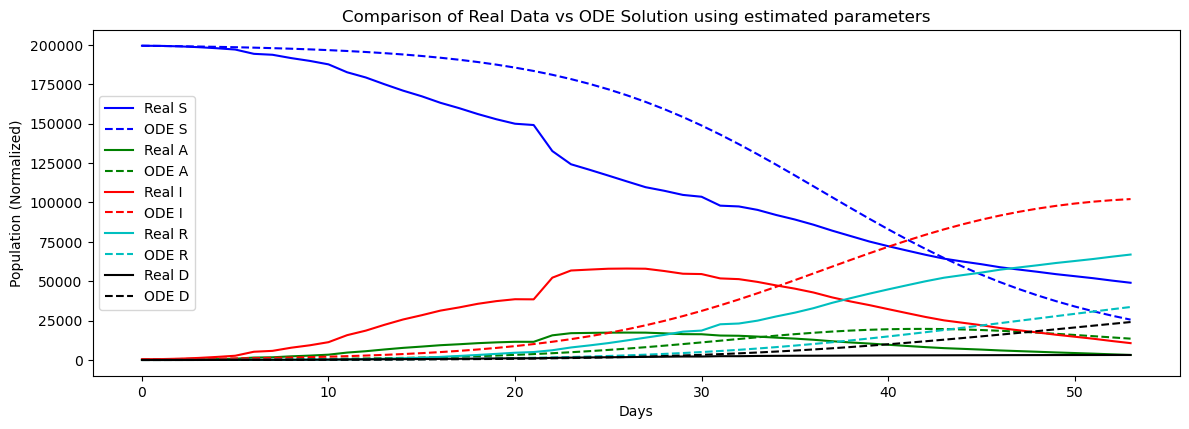

In [18]:
import pandas as pd
import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the SAIRD ODE system
def saird_ode(y, t, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda, N):
    S, A, I, R, D = y
    dS_dt = Lambda - beta1 * S * A / N - beta2 * S * I / N - mu * S
    dA_dt = beta1 * S * A / N - (gamma1 + gamma2 + gamma3) * A - mu * A
    dI_dt = beta2 * S * I / N + gamma1 * A - (kappa1 + kappa2) * I - mu * I
    dR_dt = gamma2 * A + kappa1 * I - mu * R
    dD_dt = gamma3 * A + kappa2 * I
    return [dS_dt, dA_dt, dI_dt, dR_dt, dD_dt]

# Solve the SAIRD ODE using learned parameters
def solve_saird_with_odeint(t, model, N, y0):
    # Extract learned parameters from the trained model
    beta1 = model.beta1.item()
    beta2 = model.beta2.item()
    gamma1 = model.gamma1.item()
    gamma2 = model.gamma2.item()
    gamma3 = model.gamma3.item()
    kappa1 = model.kappa1.item()
    kappa2 = model.kappa2.item()
    mu = model.mu.item()
    Lambda = model.Lambda.item()

    # Use odeint to solve the ODE
    solution = odeint(saird_ode, y0, t, args=(beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu, Lambda, N))

    return solution

# Load real data from CSV (replace with your actual file path)
def load_real_data(file_path):
    # data = pd.read_csv(file_path)
    
    # Ensure columns match ['Date', 'Susceptible', 'Asymptomatic', 'Infected', 'Recovered', 'Dead']
    t = np.arange(len(data))  # Time in days (assuming one entry per day)
    
    # Normalize data based on population size (replace 1000 with actual population size)
    N = 200000  # Replace with actual population size

    # S = torch.tensor(susceptible_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # A = torch.tensor(asymptomatic_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # I = torch.tensor(infected_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # R = torch.tensor(recovered_data.values, dtype=torch.float32).reshape(-1, 1) / N
    # D = torch.tensor(deaths_data.values, dtype=torch.float32).reshape(-1, 1) / N
    
    # S = data['Susceptible'].values / N
    # A = data['Asymptomatic'].values / N
    # I = data['Infected'].values / N
    # R = data['Recovered'].values / N
    # D = data['Dead'].values / N

    S = susceptible_data.values / N
    A = asymptomatic_data.values / N
    I = infected_data.values / N
    R = recovered_data.values / N
    D = deaths_data.values / N
    
    # Combine data into one array
    real_data = np.stack([S, A, I, R, D], axis=1)
    
    return t, real_data, N

# Main execution for solving the ODE system using real data
if __name__ == "__main__":
    # Replace 'china_covid_data.csv' with the actual path to your dataset
    file_path = 'china_covid_data.csv'
    t_real, real_data, N = load_real_data(file_path)
    
    # Initial conditions from the first row of the real data
    S0 = real_data[0, 0] * N
    A0 = real_data[0, 1] * N
    I0 = real_data[0, 2] * N
    R0 = real_data[0, 3] * N
    D0 = real_data[0, 4] * N
    y0 = [S0, A0, I0, R0, D0]  # Initial state

    # Initialize the trained model (replace with your actual trained model)
    model = SAIRD_PINN()  # Assume the model has already been trained
    # You should replace the above line with your trained model instance

    # Solve the ODE using the learned parameters
    solution = solve_saird_with_odeint(t_real, model, N, y0)
    S_ode, A_ode, I_ode, R_ode, D_ode = solution.T  # Transpose the solution

    # Plot the ODE solution vs real data
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t_real, real_data[:, 0]*N, 'b-', label="Real S")
    plt.plot(t_real, S_ode, 'b--', label="ODE S")
    
    plt.plot(t_real, real_data[:, 1]*N, 'g-', label="Real A")
    plt.plot(t_real, A_ode, 'g--', label="ODE A")
    
    plt.plot(t_real, real_data[:, 2]*N, 'r-', label="Real I")
    plt.plot(t_real, I_ode, 'r--', label="ODE I")
    
    plt.plot(t_real, real_data[:, 3]*N, 'c-', label="Real R")
    plt.plot(t_real, R_ode, 'c--', label="ODE R")
    
    plt.plot(t_real, real_data[:, 4]*N, 'k-', label="Real D")
    plt.plot(t_real, D_ode, 'k--', label="ODE D")
    
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Population (Normalized)')
    plt.title('Comparison of Real Data vs ODE Solution using estimated parameters')
    
    # Show both plots
    plt.tight_layout()
    plt.show()


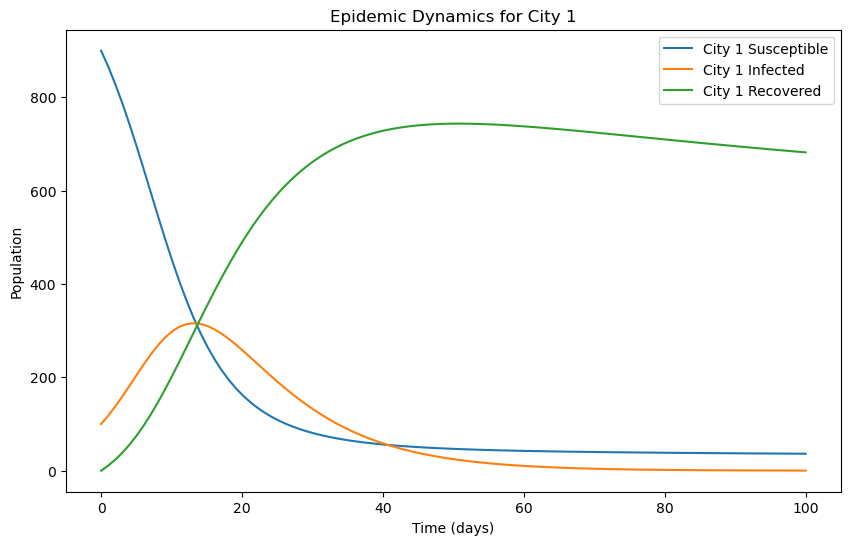

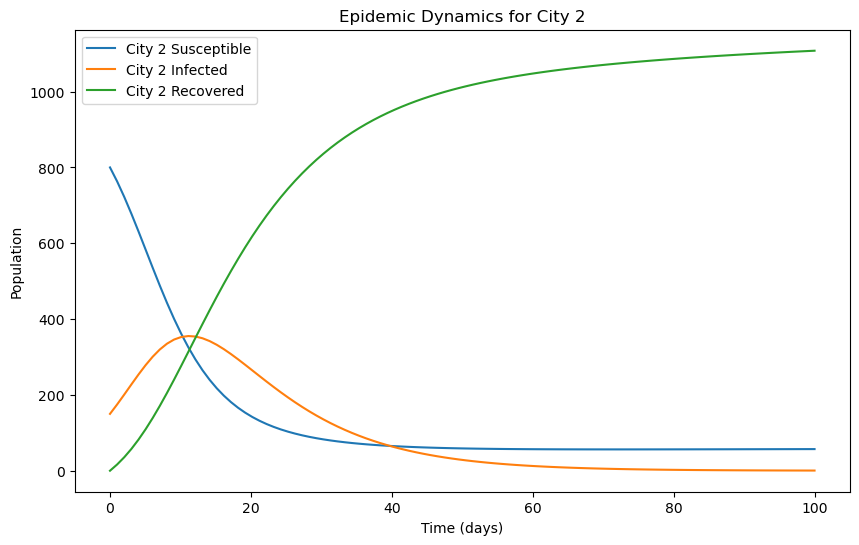

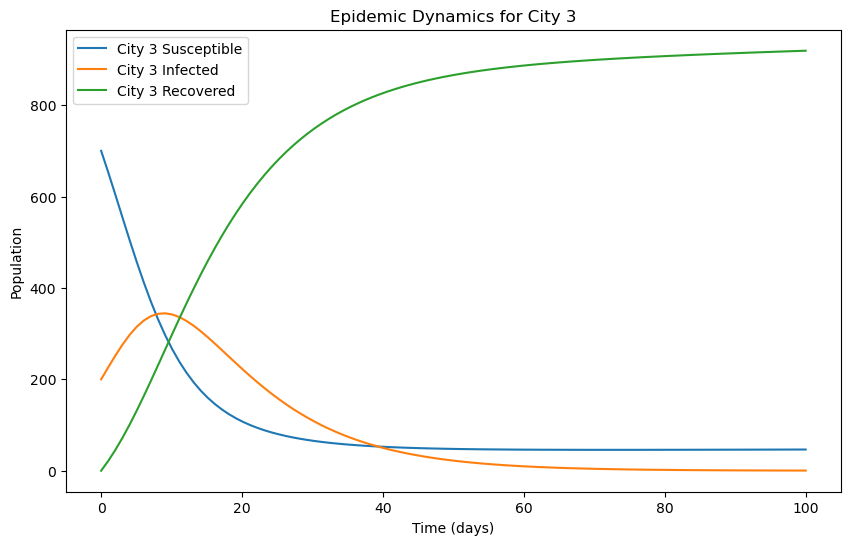

In [26]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the multi-city epidemiological model
def multi_city_model(y, t, beta, alpha, eta, A, k, delta, num_cities):
    dydt = np.zeros(3 * num_cities)
    
    for i in range(num_cities):
        X_i, Y_i, Z_i = y[i*3:(i+1)*3]
        
        # Sum over cities for interaction terms
        interaction_X = sum(A[i][j] * eta[j] / k[j] * y[j*3] for j in range(num_cities) if j != i)
        interaction_Y = sum(A[i][j] * eta[j] / k[j] * y[j*3+1] for j in range(num_cities) if j != i)
        interaction_Z = sum(A[i][j] * eta[j] / k[j] * y[j*3+2] for j in range(num_cities) if j != i)

        # Equations for city i
        dX_i_dt = -beta * X_i * Y_i / sum(y[i*3:(i+1)*3]) - eta[i] * X_i + interaction_X
        dY_i_dt = beta * X_i * Y_i / sum(y[i*3:(i+1)*3]) - alpha * Y_i - eta[i] * Y_i + interaction_Y
        dZ_i_dt = alpha * Y_i - eta[i] * Z_i + interaction_Z
        
        dydt[i*3:(i+1)*3] = [dX_i_dt, dY_i_dt, dZ_i_dt]
    
    return dydt

# Parameters for the multi-city model
def solve_multi_city_ode(beta, alpha, eta, A, k, delta, initial_conditions, t, num_cities):
    # Solve the system of ODEs
    solution = odeint(multi_city_model, initial_conditions, t, args=(beta, alpha, eta, A, k, delta, num_cities))
    return solution

# Main execution
if __name__ == "__main__":
    # Number of cities
    num_cities = 3
    
    # Time points (e.g., 100 days)
    t = np.linspace(0, 100, 100)
    
    # Initial conditions (e.g., X_i(0), Y_i(0), Z_i(0) for each city)
    initial_conditions = []
    for i in range(num_cities):
        X0 = 900 - i * 100  # Example initial susceptible population
        Y0 = 100 + i * 50   # Example initial infected population
        Z0 = 0              # Example initial recovered population
        initial_conditions.extend([X0, Y0, Z0])
    
    # Parameters (use appropriate values or estimates)
    beta = 0.3          # Transmission rate
    alpha = 0.1         # Recovery rate
    eta = [0.01, 0.01, 0.01]  # Natural death rate for each city
    
    # Adjacency matrix (e.g., A_ij = 1 if cities i and j are connected)
    A = np.array([
        [0, 0.1, 0.05],
        [0.1, 0, 0.2],
        [0.05, 0.2, 0]
    ])
    
    # Degree of each city (sum of connections)
    k = [A[i].sum() for i in range(num_cities)]
    
    # Delay in travel between cities (e.g., 1 day)
    delta = np.zeros((num_cities, num_cities))  # No delay in this example
    
    # Solve the ODE
    solution = solve_multi_city_ode(beta, alpha, eta, A, k, delta, initial_conditions, t, num_cities)
    
    # Plot the results for each city
    for i in range(num_cities):
        X_sol, Y_sol, Z_sol = solution[:, i*3:(i+1)*3].T
        
        plt.figure(figsize=(10, 6))
        plt.plot(t, X_sol, label=f"City {i+1} Susceptible")
        plt.plot(t, Y_sol, label=f"City {i+1} Infected")
        plt.plot(t, Z_sol, label=f"City {i+1} Recovered")
        plt.xlabel("Time (days)")
        plt.ylabel("Population")
        plt.title(f"Epidemic Dynamics for City {i+1}")
        plt.legend()
        plt.show()


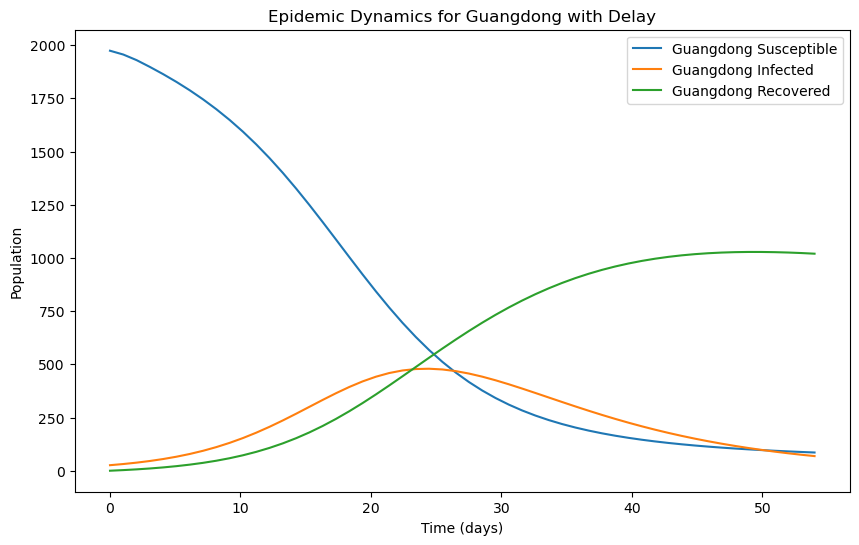

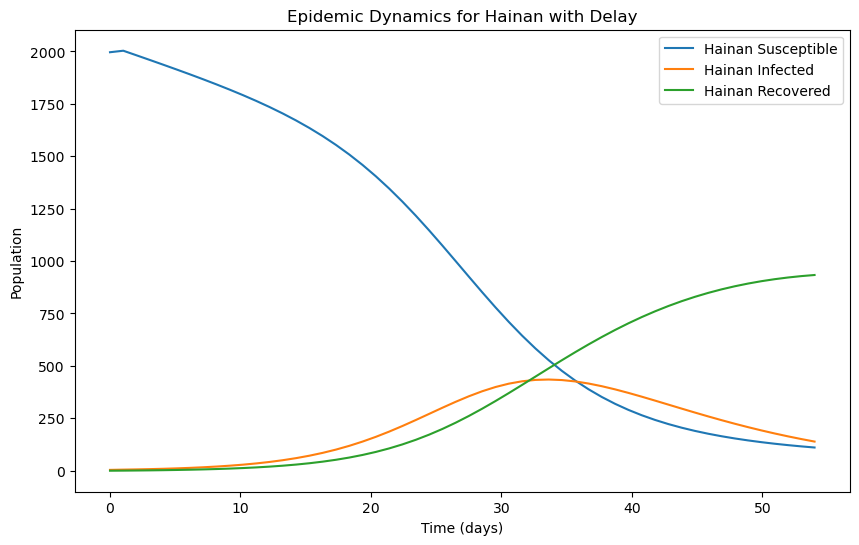

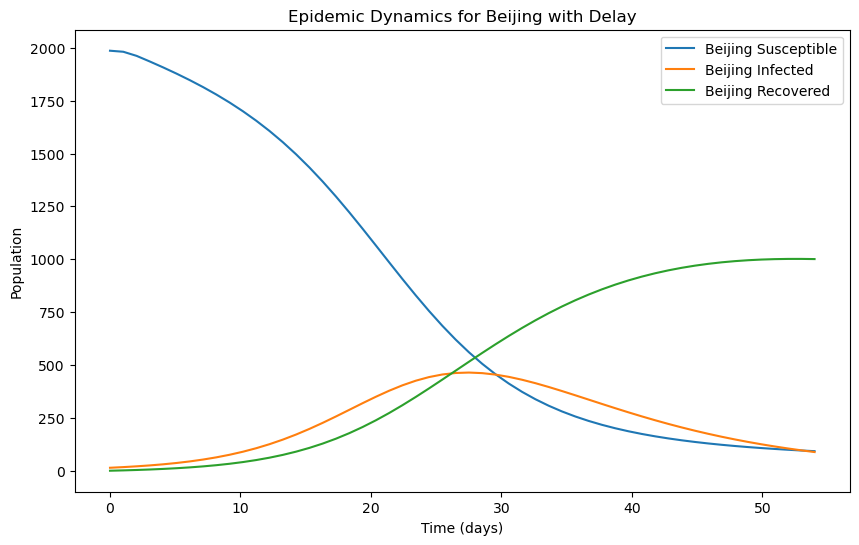

In [20]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Define the multi-city model with delay
def multi_city_model(y, t, beta, alpha, eta, A, k, delta, num_cities, interp_funcs):
    dydt = np.zeros(3 * num_cities)
    
    for i in range(num_cities):
        X_i, Y_i, Z_i = y[i*3:(i+1)*3]
        
        # Sum over cities for interaction terms, including delays
        interaction_X = 0
        interaction_Y = 0
        interaction_Z = 0
        
        for j in range(num_cities):
            if i != j:
                delay = delta[i][j]
                if t - delay >= 0:
                    X_j_delayed = interp_funcs[j*3](t - delay)
                    Y_j_delayed = interp_funcs[j*3+1](t - delay)
                    Z_j_delayed = interp_funcs[j*3+2](t - delay)
                else:
                    X_j_delayed = y[j*3]  # No delay, use current value
                    Y_j_delayed = y[j*3+1]
                    Z_j_delayed = y[j*3+2]
                
                interaction_X += A[i][j] * eta[j] / k[j] * X_j_delayed
                interaction_Y += A[i][j] * eta[j] / k[j] * Y_j_delayed
                interaction_Z += A[i][j] * eta[j] / k[j] * Z_j_delayed

        # SAIRD model equations with interaction and delay
        dX_i_dt = -beta * X_i * Y_i / (X_i + Y_i + Z_i) - eta[i] * X_i + interaction_X
        dY_i_dt = beta * X_i * Y_i / (X_i + Y_i + Z_i) - alpha * Y_i - eta[i] * Y_i + interaction_Y
        dZ_i_dt = alpha * Y_i - eta[i] * Z_i + interaction_Z
        
        dydt[i*3:(i+1)*3] = [dX_i_dt, dY_i_dt, dZ_i_dt]
    
    return dydt

# Solve the multi-city ODE with delay using odeint
def solve_multi_city_ode_with_delay(beta, alpha, eta, A, k, delta, initial_conditions, t, num_cities, interp_funcs):
    solution = odeint(multi_city_model, initial_conditions, t, args=(beta, alpha, eta, A, k, delta, num_cities, interp_funcs))
    return solution

# Load real data for each city
def load_real_data(file_paths):
    num_cities = len(file_paths)
    real_data = []
    time_data = []
    N = []
    
    for file_path in file_paths:
        data = pd.read_csv(file_path)

        # dates = pd.to_datetime(data['Observation Date'])
        # days = (dates - dates.iloc[0]).dt.days  # Convert dates to number of days since the first entry
        # time_data.append(data['Confirmed'].index.values)
        
        # Population size for each city
        city_population = 2_000  # Replace with actual population size
        N.append(city_population)
        
        # Normalize data for each compartment
        S = (city_population - data['Confirmed'].values - data['Recovered'].values - data['Deaths'].values) / city_population
        Y = data['Confirmed'].values / city_population
        Z = (data['Recovered'].values + data['Deaths'].values) / city_population
        
        # Assume asymptomatic not explicitly tracked, so use Y to represent all active cases
        real_data.append(np.stack([S, Y, Z], axis=1))
    
    return np.array(real_data), np.array(time_data), N

# Main execution for multi-city model with delay
if __name__ == "__main__":
    # Number of cities
    num_cities = 3
    
    # Replace with actual file paths for each city
    file_paths = ['Guangdong_data.csv', 'Hainan_data.csv', 'Beijing_data.csv']
    t_real = np.linspace(0, 100, 100)  # Time points over 100 days
    # t = np.arange(len(data))
    real_data, t_real, N = load_real_data(file_paths)
    t_real = np.linspace(0, 54, 54)  # Time points over 100 days
    
    # Initial conditions from the real data (first day of each city)
    initial_conditions = []
    for city_data in real_data:
        S0, Y0, Z0 = city_data[0] * N[0]  # De-normalized initial conditions
        initial_conditions.extend([S0, Y0, Z0])
    
    # Parameters (example values)
    beta = 0.3           # Transmission rate
    alpha = 0.1          # Recovery rate
    eta = [0.01, 0.01, 0.01]  # Natural death rate for each city
    
    # Adjacency matrix (representing travel/connection between cities)
    A = np.array([
        [0, 0.1, 0.05],
        [0.1, 0, 0.2],
        [0.05, 0.2, 0]
    ])
    
    # Degree of each city (sum of connections)
    k = [A[i].sum() for i in range(num_cities)]
    
    # Delay in travel between cities (days)
    delta = np.array([
        [0, 1, 2],  # City 1 to City 2: 1 day, City 1 to City 3: 2 days
        [1, 0, 1],  # City 2 to City 1: 1 day, City 2 to City 3: 1 day
        [2, 1, 0]   # City 3 to City 1: 2 days, City 3 to City 2: 1 day
    ])
    
    # Interpolation functions to handle delay
    interp_funcs = []
    for city_data in real_data:
        for i in range(3):  # For S, Y, Z
            interp_func = interp1d(t_real, city_data[:, i], kind='linear', fill_value='extrapolate')
            interp_funcs.append(interp_func)
    # for i in range(num_cities):
    #     city_data = real_data[i]
    #     city_time = t_real[i]
    #     for j in range(3):  # For S, Y, Z
    #         interp_func = interp1d(city_time, city_data[:, j], kind='linear', fill_value='extrapolate')
    #         interp_funcs.append(interp_func)
    
    # Solve the ODE with delay
    solution = solve_multi_city_ode_with_delay(beta, alpha, eta, A, k, delta, initial_conditions, t_real, num_cities, interp_funcs)
    name_city = ['Guangdong', 'Hainan', 'Beijing']
    num_city = [0, 1, 2]
    # Plot the results for each city
    # for i in range(num_cities):
    for i, j in zip(num_city, name_city):
        S_sol, Y_sol, Z_sol = solution[:, i*3:(i+1)*3].T
        
        plt.figure(figsize=(10, 6))
        plt.plot(t_real, S_sol, label=f"{j} Susceptible")
        plt.plot(t_real, Y_sol, label=f"{j} Infected")
        plt.plot(t_real, Z_sol, label=f"{j} Recovered")
        plt.xlabel("Time (days)")
        plt.ylabel("Population")
        plt.title(f"Epidemic Dynamics for {j} with Delay")
        plt.legend()
        plt.show()


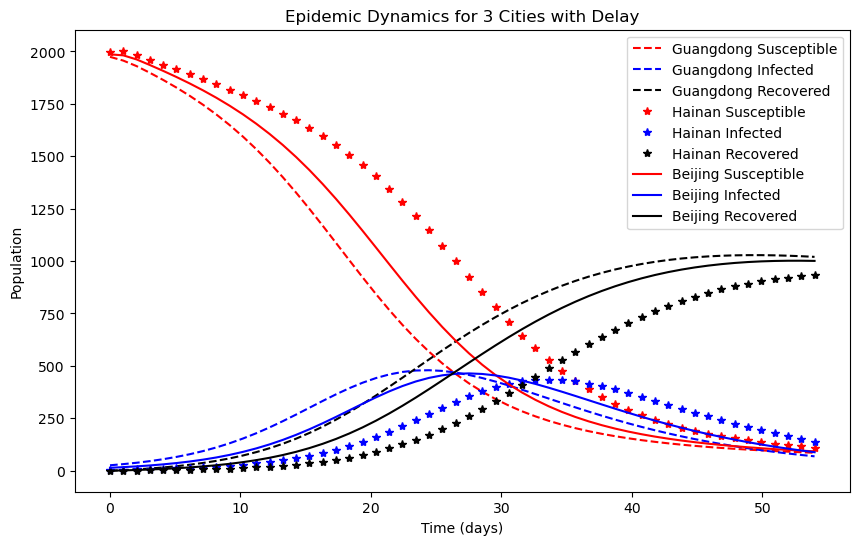

In [25]:
S_sol_1, Y_sol_1, Z_sol_1 = solution[:, :3].T
S_sol_2, Y_sol_2, Z_sol_2 = solution[:, 3:6].T
S_sol_3, Y_sol_3, Z_sol_3 = solution[:, 6:9].T
        
plt.figure(figsize=(10, 6))
plt.plot(t_real, S_sol_1, 'r--', label=f"Guangdong Susceptible")
plt.plot(t_real, Y_sol_1, 'b--', label=f"Guangdong Infected")
plt.plot(t_real, Z_sol_1, 'k--', label=f"Guangdong Recovered")
plt.plot(t_real, S_sol_2, 'r*', label=f"Hainan Susceptible")
plt.plot(t_real, Y_sol_2, 'b*', label=f"Hainan Infected")
plt.plot(t_real, Z_sol_2, 'k*', label=f"Hainan Recovered")
plt.plot(t_real, S_sol_3, 'r-', label=f"Beijing Susceptible")
plt.plot(t_real, Y_sol_3, 'b-', label=f"Beijing Infected")
plt.plot(t_real, Z_sol_3, 'k-', label=f"Beijing Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title(f"Epidemic Dynamics for 3 Cities with Delay")
plt.legend()
plt.show()

In [41]:
import pandas as pd

df = pd.read_csv('China_edited_data.csv')


In [42]:
import plotly_express as px

fig = px.density_mapbox(df, lat='Latitude',lon='Longitude', z='Confirmed', radius=20, center=dict(lat=df.Latitude.mean(), lon=df.Longitude.mean()), zoom=4, mapbox_style='open-street-map', height=900)
fig.show()

In [46]:
import folium

m = folium.Map(location=[df.Latitude.mean(), df.Longitude.mean()], zoom_start=6, control_scale=True)

In [47]:
map_values = df[['Observation Date', 'Latitude', 'Longitude', 'Confirmed']]
data = map_values.values.tolist()

In [48]:
import folium.plugins


hm = folium.plugins.HeatMap(data=data, min_opacity=0.05, max_opacity=0.8, radius=25).add_to(m)

m

ValueError: Location should consist of two numerical values, but '22-01-2020' of type <class 'str'> is not convertible to float.

In [49]:
hm = folium.plugins.HeatMapWithTime(data=data,auto_play = True, max_speed = 100, min_opacity=0.05, max_opacity=0.8, radius=25).add_to(m)

m

In [ ]:
week_days = 7
interval_sec = 86400
total_time = 86400*week_days
import numpy as np
time_index = []
for _time in np.arange(interval_sec, total_time+interval_sec, interval_sec):
    time_index.append(_time)
import datetime
import math
geoms_ts_list = []
geoms_ts_sample_ids = []
ref_ts = data_fleet_ts.timestamp_UTC[0].timestamp()
for index, row in data_fleet_ts.iterrows():
    row_ts = data_fleet_ts.timestamp_UTC[index].timestamp()-ref_ts
    geoms_ts_list.append(row_ts)
    geoms_ts_sample_ids.append(math.floor(row_ts/interval_sec))
current_sample_id = 0
geoms_time_plot = []
geoms_time_plot_sample = []
weight = 0.05
weight *= 120/interval_sec
for idx, sample_id in enumerate(geoms_ts_sample_ids):
    if sample_id == current_sample_id:
        geoms_time_plot_sample.append([data_fleet[idx][0], data_fleet[idx][1], weight])
    elif sample_id == current_sample_id+1:
        geoms_time_plot.append(geoms_time_plot_sample)
        geoms_time_plot_sample = [[data_fleet[idx][0], data_fleet[idx][1], weight]]
        current_sample_id += 1
    if idx == len(geoms_ts_sample_ids)-1:    
        geoms_time_plot.append(geoms_time_plot_sample)
    if geoms_ts_list[idx] >= total_time:    
         break

time_index_display = [str(datetime.datetime.fromtimestamp(_time+ref_ts-interval_sec)) for _time in time_index] 

import folium
map_time = folium.Map(
    location=[40.4,-3.7],
    tiles="CartoDB positron",
    zoom_start= 6,
    control_scale=True
)
from folium.plugins import HeatMapWithTime
HeatMapWithTime(data=geoms_time_plot, 
                index = time_index_display,
                auto_play = True, 
                max_speed = 10, 
                radius = 12, 
                blur = .8,
                min_opacity = 0,
                max_opacity = .8,
                ).add_to(map_time)
Save the map:
name = "HeatMapWithTime_AstaraConnect.html"
map_time.save(name)